<a href="https://colab.research.google.com/github/yaaili/test/blob/master/tf2.0/06%E7%8C%AB%E7%8B%97%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 导入相关包
from google.colab import drive
drive.mount('/content/gdrive')
import os

os.chdir("/content/gdrive/My Drive/Colab Notebooks/tensorflow")

import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tensorflow version: 2.2.0-rc4


# 1. 本文的应用场景是二分类问题，采用的数据集为猫狗分类数据集，训练集图片有2000张，验证集的图片有1000张，分为猫和狗两个类别，图片已经放置在猫狗数据集_2000文件夹下面。

## 2.1 加载图片

In [0]:
#配置数据集路径
path_root = os.path.join(os.path.realpath("."),"DS","dc_2000")
data_dir = pathlib.Path(path_root)

#数量构成
train_image_count = len(list(data_dir.glob('train/*/*.jpg')))
test_image_count = len(list(data_dir.glob('test/*/*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*')])
print("训练集的数量:{}\n验证集的数量:{}\n数据集类别:{}".format(train_image_count,test_image_count,CLASS_NAMES))

#保存文件的路径,随机打乱
import random  
train_all_image_path = list(data_dir.glob("train/*/*"))
test_all_image_path = list(data_dir.glob("test/*/*"))
train_all_image_path = [str(path) for path in train_all_image_path]
test_all_image_path = [str(path) for path in test_all_image_path]

random.shuffle(train_all_image_path)
random.shuffle(test_all_image_path)

训练集的数量:3032
验证集的数量:1000
数据集类别:['cat' 'dog']


## 2.2 读取图片


{'cat': 0, 'dog': 1}



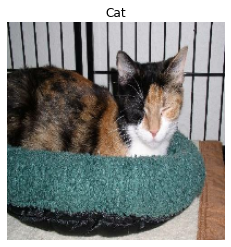

In [0]:
#确定每个图像的标签
lable_names = sorted(item.name for item in data_dir.glob("train/*/"))
#为每个标签分配索引,构建字典
lable_to_index = dict((name,index) for index,name in enumerate(lable_names))
print(lable_to_index)
#创建一个列表，包含每个文件的标签索引
train_image_label = [lable_to_index[pathlib.Path(path).parent.name] for path in train_all_image_path]
test_image_label = [lable_to_index[pathlib.Path(path).parent.name] for path in test_all_image_path]
#包装为函数，以备后用
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [200, 200])
    image /= 255.0  # normalize to [0,1] range
    return image


#加载图片
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


image_path = test_all_image_path[11]
label = test_image_label[11]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
##plt.xlabel(caption_image(image_path))
plt.title(lable_names[label].title())
plt.axis("off")
print()

# 3 图片预处理
在这一部分我们采用from_tensor_slices的方法对图片数据集进行构建，对比tf1.x版本采用队列形式读取数据，这一种方法比较简单切易于理解。
## 3.1 构建（图片，标签）对数据集

In [0]:
#构建一个tf.data.Dataset
#一个图片数据集构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。
#将字符串数组切片，得到一个字符串数据集：
train_path_ds =  tf.data.Dataset.from_tensor_slices(train_all_image_path)
print(train_path_ds)
test_path_ds =  tf.data.Dataset.from_tensor_slices(test_all_image_path)
#现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image来动态加载和格式化图片。
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_image_ds = train_path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)
test_image_ds = test_path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)
train_lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_label,tf.int64))
test_lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_image_label,tf.int64))
for label in train_lable_ds.take(5):
    print(lable_names[label.numpy()])
#%%构建一个（图片，标签）对数据集
#因为这些数据集顺序相同，可以将他们打包起来
image_label_ds = tf.data.Dataset.zip((train_image_ds,train_lable_ds))
test_data = tf.data.Dataset.zip((test_image_ds,test_lable_ds))
print(test_data)

#注意：当你拥有形似 all_image_labels 和 all_image_paths 的数组，tf.data.dataset.Dataset.zip 的替代方法是将这对数组切片
# =================================im============================================
# ds = tf.data.Dataset.from_tensor_slices((all_image_path,all_image_label))
# def load_and_preprocess_from_path_label(path, label):  
#     return load_and_preprocess_image(path),label
# image_label_ds = ds.map(load_and_preprocess_from_path_label)    
# =============================================================================

<TensorSliceDataset shapes: (), types: tf.string>
cat
dog
cat
dog
cat
<ZipDataset shapes: ((200, 200, 3), ()), types: (tf.float32, tf.int64)>


# 4. 训练阶段

In [0]:
#%%设置训练数据和测试数据的大小
test_count = int(train_image_count*0.3)
train_count = train_image_count - test_count
print(test_count,train_count)
#跳过test_count个
train_dataset = image_label_ds.skip(test_count)
test_dataset = image_label_ds.take(test_count)

909 2123


In [0]:
batch_size = 32
# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据被充分打乱。
train_ds = train_dataset.shuffle(buffer_size=train_count).repeat().batch(batch_size)
test_ds = test_dataset.batch(batch_size)

## 4.1 构建模型

In [0]:
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(200, 200, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#%%
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 256)       2

In [0]:
steps_per_eooch = train_count//batch_size
validation_steps = test_count//batch_size

history = model.fit(train_ds,epochs=100,steps_per_epoch=steps_per_eooch,validation_data=test_ds,validation_steps=validation_steps)

Epoch 1/100
66/66 [==============================] - 11s 171ms/step - loss: 0.6936 - acc: 0.5208 - val_loss: 0.6931 - val_acc: 0.4833
Epoch 2/100
66/66 [==============================] - 11s 169ms/step - loss: 0.6902 - acc: 0.5312 - val_loss: 0.6919 - val_acc: 0.5502
Epoch 3/100
66/66 [==============================] - 11s 168ms/step - loss: 0.6851 - acc: 0.5611 - val_loss: 0.6799 - val_acc: 0.6105
Epoch 4/100
66/66 [==============================] - 17s 254ms/step - loss: 0.6650 - acc: 0.6080 - val_loss: 0.6568 - val_acc: 0.6228
Epoch 5/100
66/66 [==============================] - 17s 257ms/step - loss: 0.6341 - acc: 0.6501 - val_loss: 0.6466 - val_acc: 0.6395
Epoch 6/100
66/66 [==============================] - 17s 259ms/step - loss: 0.6207 - acc: 0.6581 - val_loss: 0.6594 - val_acc: 0.5826
Epoch 7/100
66/66 [==============================] - 17s 254ms/step - loss: 0.6174 - acc: 0.6529 - val_loss: 0.6691 - val_acc: 0.5938
Epoch 8/100
66/66 [==============================] - 17s 255ms

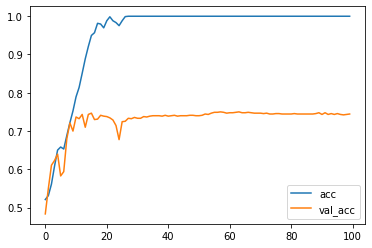

In [0]:
history.history.keys()
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

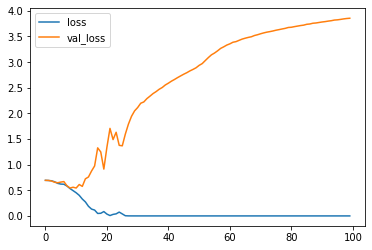

In [0]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

In [0]:
#test_ds = test_data.batch(batch_size)
loss,acc = model.evaluate(test_data.batch(batch_size))

32/32 [==============================] - 4s 111ms/step - loss: 3.8820 - acc: 0.7300
